In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '../..')
import ana_cont.continuation as cont

# Square lattice Hubbard model, $U=2$, $\beta=5$, half-filling

## Analytic continuation of self-energy

In [2]:
# load data
siw = np.load('data/square_U2_b5/siw.npy')
err = np.load('data/square_U2_b5/siw_err.npy')
beta = 5.
mu = 1.

In [3]:
# define the problem
niw = 100  # number of Matsubara frequencies
iw = np.pi / beta * (2. * np.arange(niw) + 1.)  # fermionic Matsubara frequencies

w = np.linspace(-20., 20., num=501, endpoint=True)  # real-frequency grid
model = np.ones_like(w)  # flat default model
model /= np.trapz(model, w)  # normalization, not strictly necessary

# the problem is defined by: imaginary grid, real grid, data, kernel type
probl = cont.AnalyticContinuationProblem(im_axis=iw,  # imaginary grid
                                         re_axis=w,  # real grid
                                         im_data=1j * siw.imag[:niw],  # data 
                                         kernel_mode='freq_fermionic')  # kernel type

501 data points on real axis
200 data points on imaginary axis
31 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 12.00,	chi2 = 4.238e+06,   S = -5.061e-11,   nfev = 2,   norm = 1.000
log10(alpha) = 11.00,	chi2 = 4.236e+06,   S = -5.058e-09,   nfev = 11,   norm = 1.000
log10(alpha) = 10.00,	chi2 = 4.218e+06,   S = -5.030e-07,   nfev = 17,   norm = 1.001
log10(alpha) = 9.00,	chi2 = 4.045e+06,   S = -4.756e-05,   nfev = 22,   norm = 1.008
log10(alpha) = 8.00,	chi2 = 2.898e+06,   S = -2.878e-03,   nfev = 26,   norm = 1.062
log10(alpha) = 7.00,	chi2 = 1.088e+06,   S = -3.482e-02,   nfev = 28,   norm = 1.179
log10(alpha) = 6.00,	chi2 = 2.258e+05,   S = -1.751e-01,   nfev = 34,   norm = 1.133
log10(alpha) = 5.00,	chi2 = 2.230e+04,   S = -4.523e-01,   nfev = 88,   norm = 1.047
log10(alpha) = 4.00,	chi2 = 1.078e+03,   S = -6.940e-01,   nfev = 40,   norm = 1.012
log10(alpha) = 3.00,	chi2 = 8.521e+01,   S = -8.045e-01,   nfev = 51,   norm = 1.003
log10(alpha)

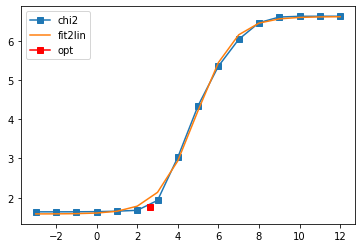

In [4]:
# most basic way to solve the problem
sol, _ = probl.solve(method='maxent_svd',  # Maxent solver that works with singular value decomp.
                     optimizer='newton',  # newton root finding for the optimization problem
                     alpha_determination='chi2kink',
                     model=model,  # default model
                     stdev=err[:niw],  # standard deviation of the data
                     alpha_start=1e12,  # largest alpha, starting value
                     interactive=True)

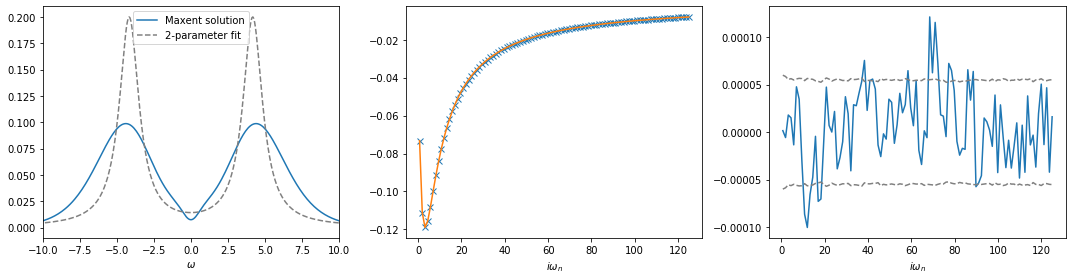

In [5]:
# load fitted self-energy
w_fit, sw_fit = np.load('data/square_U2_b5/sw_fit.npy').T

#plot results
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
ax[0].plot(w, sol.A_opt, label='Maxent solution')
ax[0].plot(w_fit, sw_fit, color='gray', ls='--', label='2-parameter fit')
ax[0].legend()
ax[0].set_xlim(-10., 10.)
ax[0].set_xlabel(r'$\omega$')
ax[1].plot(iw, siw.imag[:niw], marker='x', ls='None')
ax[1].plot(iw, sol.backtransform.imag)
ax[1].set_xlabel(r'$i\omega_n$')
ax[2].plot(iw, (siw[:niw] - sol.backtransform).imag)
ax[2].plot(iw, err[:niw], ls='--', color='gray')
ax[2].plot(iw, -err[:niw], ls='--', color='gray')
ax[2].set_xlabel(r'$i\omega_n$')
plt.tight_layout()
plt.show()

In [6]:
# more sophisticated solution, using preblur

bw = [0., 0.5, 1., 1.5, 1.75]  # some values for the blur width
bt_list = []  # here we store the backtransform arrays
spec_list = []  # here we store the spectral functions
chi_list= []  # here we store the chi2 deviation

for i in range(len(bw)):  # loop over some values of the blur width
    sol, sol_all = probl.solve(method='maxent_svd',  # Maxent solver that works with singular value decomp.
                         optimizer='newton',  # newton root finding for the optimization problem
                         alpha_determination='chi2kink',
                         model=model,  # default model
                         stdev=err[:niw],  # standard deviation of the data
                         preblur=bw[i]>0.,  # switch on preblur if blur_width > 0.
                         blur_width=bw[i],  # 1. is good, 1.5 is limit
                         alpha_start=1e12,  # largest alpha, starting value
                         interactive=False,
                         verbose=False)
    bt_list.append(sol.backtransform)
    spec_list.append(sol.A_opt)
    chi_list.append(sol_all[-1].chi2)

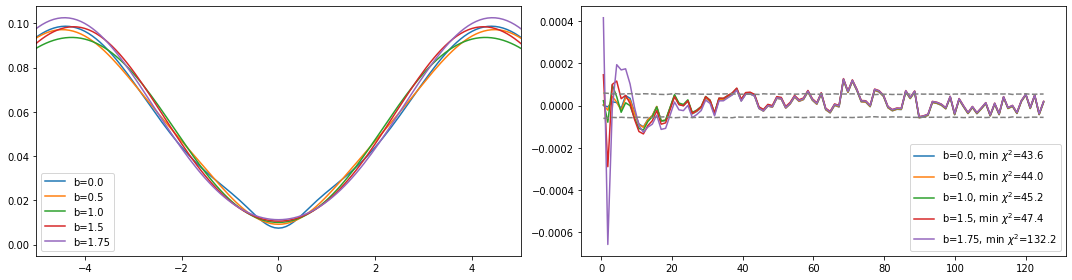

In [7]:
#plot results
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))
for i in range(len(bw)):
    ax[0].plot(w, spec_list[i], label='b={}'.format(bw[i]))
ax[0].legend()
ax[0].set_xlim(-5., 5.)
for i in range(len(bw)):
    ax[1].plot(iw, (siw[:niw] - bt_list[i]).imag, 
               label='b={}, min $\chi^2$={:.1f}'.format(bw[i], chi_list[i]))
ax[1].plot(iw, err[:niw], ls='--', color='gray')
ax[1].plot(iw, -err[:niw], ls='--', color='gray')
ax[1].legend()
plt.tight_layout()
plt.show()

In [8]:
# take b=1., which is list element #2 (in zero-based indexing)
sw = cont.GreensFunction(spectrum=spec_list[2], wgrid=w, kind='fermionic').kkt() + 1.

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


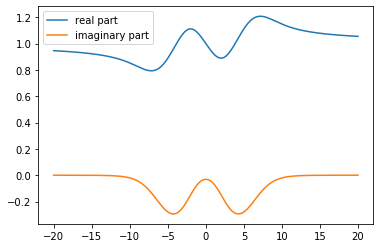

In [9]:
plt.plot(w, sw.real, label='real part')
plt.plot(w, sw.imag, label='imaginary part')
plt.legend()
plt.show()

## Calculate spectrum from self-energy and DOS

In cases where the self-energy is proportional to a unit matrix in orbital space,
we can calculate the spectral function from the non-interacting DOS $A_0(\omega)$ and the self-energy
in real frequencies as
$$
A(\omega) = -\frac{1}{\pi} \mathrm{Im}\; \int_\text{band} d\omega' \frac{A_0(\omega')}{\omega - \omega' + \mu - \Sigma(\omega)}
$$

In [10]:
from scipy.special import ellipk
w_dos = np.linspace(-5., 5., num=1000, endpoint=True)
dos = np.nan_to_num(ellipk(np.sqrt(1. - (w_dos / 4.)**2)**2) / (2. * np.pi**2))

/home/josef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
g_from_s = np.trapz(dos[None, :] 
                    / (w[:, None] + mu - w_dos[None, :] - sw[:, None]),
                    w_dos, axis=1)

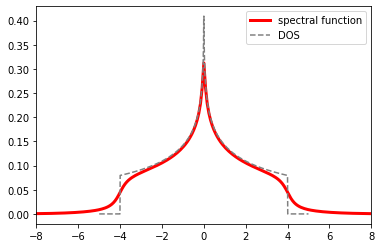

In [12]:
plt.plot(w, -g_from_s.imag / np.pi, color='red', lw=3., label='spectral function')
plt.plot(w_dos, dos, color='gray', ls='--', label='DOS')
plt.xlim(-8., 8.)
plt.legend()
plt.show()

## Direct analytic continuation of the Green's function

In [13]:
giw = np.load('data/square_U2_b5/giw.npy')
err_g = np.ones_like(giw, dtype=np.float) * 1e-4

In [14]:
niw_g = 100
iw_g = np.pi / beta * (2. * np.arange(niw_g) + 1.)

w_g = np.linspace(-12., 12., num=501, endpoint=True)
model = np.ones_like(w_g)
model /= np.trapz(model, w_g)  # normalization, not strictly necessary

probl = cont.AnalyticContinuationProblem(im_axis=iw_g, 
                                         re_axis=w_g, 
                                         im_data=1j * giw.imag[:niw_g], 
                                         kernel_mode='freq_fermionic')

501 data points on real axis
200 data points on imaginary axis
27 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 11.00,	chi2 = 2.113e+07,   S = -1.867e-08,   nfev = 10,   norm = 1.000
log10(alpha) = 10.00,	chi2 = 2.106e+07,   S = -1.866e-06,   nfev = 18,   norm = 1.001
log10(alpha) = 9.00,	chi2 = 2.039e+07,   S = -1.857e-04,   nfev = 24,   norm = 1.011
log10(alpha) = 8.00,	chi2 = 1.432e+07,   S = -1.636e-02,   nfev = 28,   norm = 1.102
log10(alpha) = 7.00,	chi2 = 1.698e+06,   S = -2.150e-01,   nfev = 28,   norm = 1.281
log10(alpha) = 6.00,	chi2 = 2.101e+05,   S = -4.029e-01,   nfev = 33,   norm = 1.173
log10(alpha) = 5.00,	chi2 = 1.556e+04,   S = -6.481e-01,   nfev = 34,   norm = 1.056
log10(alpha) = 4.00,	chi2 = 9.667e+02,   S = -8.289e-01,   nfev = 61,   norm = 1.013
log10(alpha) = 3.00,	chi2 = 2.968e+01,   S = -9.280e-01,   nfev = 54,   norm = 1.003
log10(alpha) = 2.00,	chi2 = 1.042e+00,   S = -9.596e-01,   nfev = 31,   norm = 1.000
log10(alpha)

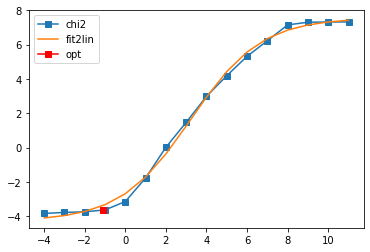

In [15]:
sol, _ = probl.solve(method='maxent_svd',
                     optimizer='newton',
                     alpha_determination='chi2kink',
                     model=model,
                     stdev=err_g[:niw_g],
                     interactive=True, 
                     alpha_start=1e11, 
                     alpha_end=1e-4)

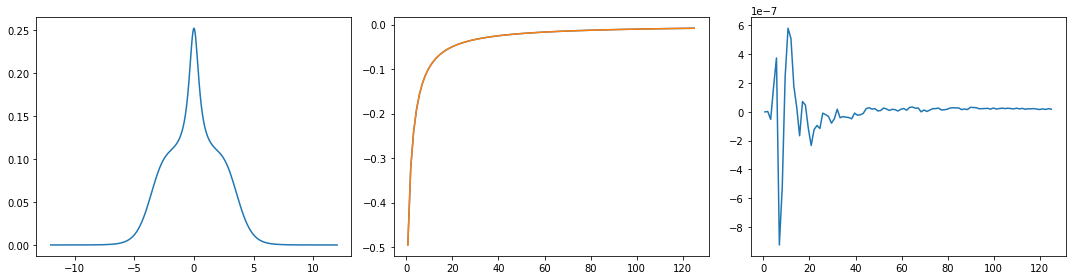

In [16]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
ax[0].plot(w_g, sol.A_opt)
ax[1].plot(iw_g, giw.imag[:niw_g])
ax[1].plot(iw_g, sol.backtransform.imag)
ax[2].plot(iw_g, (giw[:niw_g] - sol.backtransform).imag)
plt.tight_layout()
plt.show()

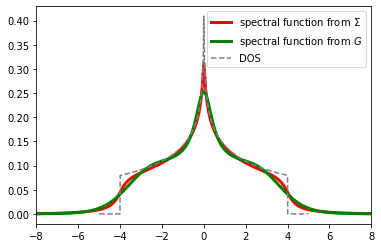

In [17]:
plt.plot(w, -g_from_s.imag / np.pi, color='red', lw=3., label=r'spectral function from $\Sigma$')
plt.plot(w_g, sol.A_opt, color='green', alpha=1., lw=3., label=r'spectral function from $G$')
plt.plot(w_dos, dos, color='gray', ls='--', label='DOS')
plt.xlim(-8., 8.)
plt.legend()
plt.show()

# Strontium vanadate

In [18]:
siw = np.load('data/svo/siw.npy')
err = np.load('data/svo/siw_err.npy')
hartree = np.load('data/svo/hartree.npy')
beta = np.load('data/svo/beta.npy')

In [19]:
niw = 300
iw = np.pi / beta * (2. * np.arange(niw) + 1.)

# here we want a non-equispaced grid to cover a larger interval
w = 30 * np.tan(np.linspace(-np.pi/2.1, np.pi/2.1, num=501, endpoint=True)) / np.tan(np.pi / 2.1)
model = np.exp(-(w / 20)**6)  # smooth cut-off at |w| > 20
model /= np.trapz(model, w) / 4.77  # normalization, not strictly necessary

probl = cont.AnalyticContinuationProblem(im_axis=iw, 
                                         re_axis=w, 
                                         im_data=siw[:niw]-hartree, 
                                         kernel_mode='freq_fermionic')

501 data points on real axis
600 data points on imaginary axis
51 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 12.00,	chi2 = 5.181e+07,   S = -3.514e-10,   nfev = 5,   norm = 4.770
log10(alpha) = 11.00,	chi2 = 5.179e+07,   S = -3.513e-08,   nfev = 13,   norm = 4.770
log10(alpha) = 10.00,	chi2 = 5.167e+07,   S = -3.507e-06,   nfev = 19,   norm = 4.772
log10(alpha) = 9.00,	chi2 = 5.042e+07,   S = -3.444e-04,   nfev = 24,   norm = 4.787
log10(alpha) = 8.00,	chi2 = 3.975e+07,   S = -2.854e-02,   nfev = 31,   norm = 4.937
log10(alpha) = 7.00,	chi2 = 9.856e+06,   S = -5.861e-01,   nfev = 81,   norm = 5.640
log10(alpha) = 6.00,	chi2 = 1.282e+06,   S = -1.744e+00,   nfev = 45,   norm = 5.621
log10(alpha) = 5.00,	chi2 = 9.610e+04,   S = -3.252e+00,   nfev = 48,   norm = 5.080
log10(alpha) = 4.00,	chi2 = 6.853e+03,   S = -4.306e+00,   nfev = 40,   norm = 4.853
log10(alpha) = 3.00,	chi2 = 5.785e+02,   S = -5.065e+00,   nfev = 72,   norm = 4.782
log10(alpha)

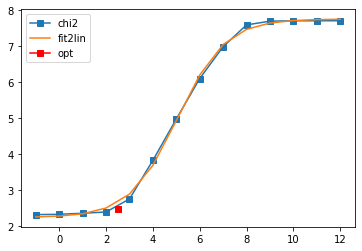

In [20]:
sol, _ = probl.solve(method='maxent_svd',
                     optimizer='newton',
                     alpha_determination='chi2kink',
                     model=model,
                     stdev=err[:niw],
                     preblur=True,
                     blur_width=0.3,
                     interactive=True,
                     alpha_start=1e12,
                     alpha_end=1e-1)

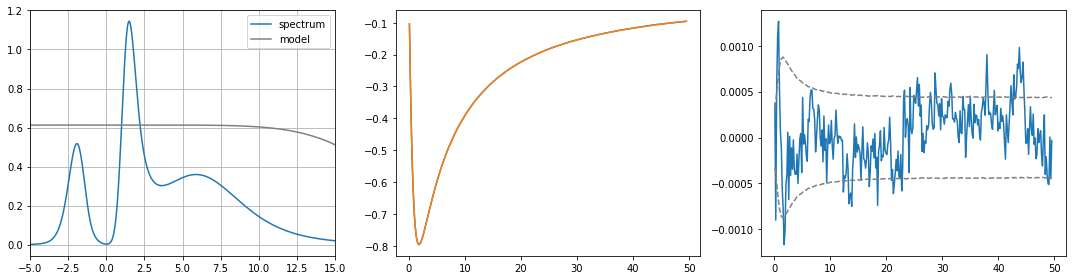

In [21]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
ax[0].plot(w, sol.A_opt, label='spectrum')
ax[0].plot(w, model * sol.norm, color='gray', label='model')
ax[0].legend()
ax[0].set_xlim(-5., 15.)
ax[0].grid()
ax[1].plot(iw, siw.imag[:niw])
ax[1].plot(iw, sol.backtransform.imag)
ax[2].plot(iw, (siw[:niw] - sol.backtransform).imag)
ax[2].plot(iw, err[:niw], ls='--', color='gray')
ax[2].plot(iw, -err[:niw], ls='--', color='gray')
plt.tight_layout()
plt.show()

# Analytical continuation of a matrix-valued function (Kagome)

As an example for matrix-valued analytical continuation we take a D$\Gamma$A self-energy
for the kagome Hubbard model at $U=6t$, $\beta=3/t$, half-filling, for a certain $\mathbf{k}$-point.

There, the self-energy is a 3$\times$3-matrix, with non-zero offdiagonal elements. 
In this case we are lucky and the projection of the self-energy on the eigenstates
of the tight-binding Hamiltonian for this $\mathbf{k}$-point is diagonal. 
This means that here we have two ways of doing the analytic continuation:
1. Via projections:
  * Project self-energy on eigenbasis of tb-Hamiltonian
  * Continue only the diagonal elements (standard problem)
  * Rotate back to original basis
2. Direct
  * Continue the diagonal elements in original basis (standard problem)
  * construct better default model for offdiag elements
  * continue the offdiag elements (pos-neg problem)
  
In the end we can compare both results.

In [22]:
# load data
siw = np.load('data/kagome_offdiag/siw.npy')  # DGA self-energy at certain k-point
states = np.load('data/kagome_offdiag/states.npy')  # eigenstates of tb-Hamiltonian at this k-point
hartree = 3.  # for U=6 and half-filling
beta = 3.
niw = siw.shape[0]
iw = np.pi / beta * (2. * np.arange(niw) + 1.)

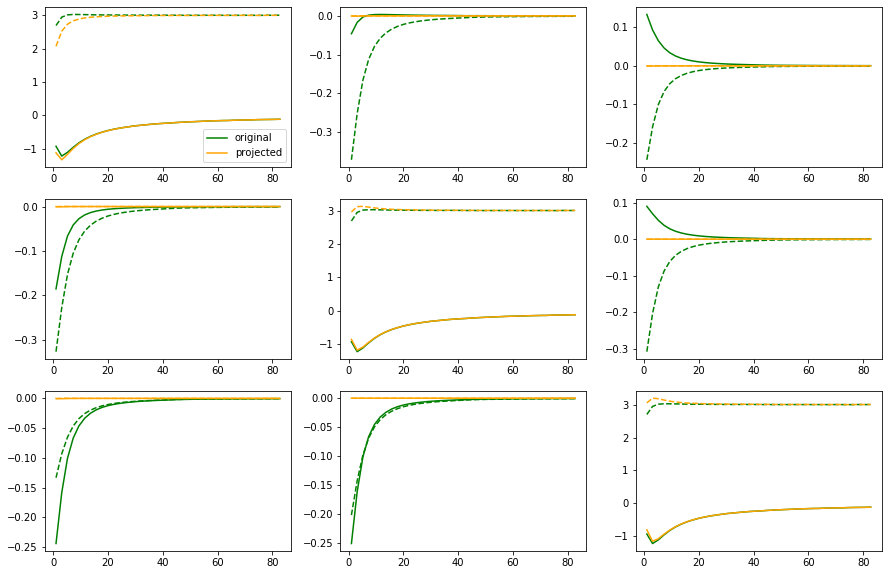

In [23]:
# project self-energy to Hamiltonian eigenbasis
siw_projected = states.T.conj() @ siw @ states

# plot original and projected matrix elements
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15, 10))
for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        ax[i, j].plot(iw, siw[:, i, j].real, color='green', ls='--')
        ax[i, j].plot(iw, siw[:, i, j].imag, color='green', ls='-', label='original')
        ax[i, j].plot(iw, siw_projected[:, i, j].real, color='orange', ls='--')
        ax[i, j].plot(iw, siw_projected[:, i, j].imag, color='orange', ls='-', label='projected')
ax[0, 0].legend()
plt.show()

401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 9.00,	chi2 = 6.783e+05,   S = -4.278e-08,   nfev = 7,   norm = 9.001
log10(alpha) = 8.00,	chi2 = 6.767e+05,   S = -4.272e-06,   nfev = 16,   norm = 9.005
log10(alpha) = 7.00,	chi2 = 6.615e+05,   S = -4.214e-04,   nfev = 21,   norm = 9.050
log10(alpha) = 6.00,	chi2 = 5.274e+05,   S = -3.608e-02,   nfev = 26,   norm = 9.466
log10(alpha) = 5.00,	chi2 = 1.281e+05,   S = -7.818e-01,   nfev = 29,   norm = 11.124
log10(alpha) = 4.00,	chi2 = 2.349e+04,   S = -2.224e+00,   nfev = 31,   norm = 11.403
log10(alpha) = 3.00,	chi2 = 1.953e+03,   S = -5.132e+00,   nfev = 62,   norm = 10.332
log10(alpha) = 2.00,	chi2 = 1.346e+02,   S = -7.279e+00,   nfev = 55,   norm = 9.823
log10(alpha) = 1.00,	chi2 = 2.966e+01,   S = -8.397e+00,   nfev = 54,   norm = 9.684
log10(alpha) = 0.00,	chi2 = 2.604e+01,   S = -8.865e+00,   nfev = 72,   norm = 9.663
log10(alpha) 

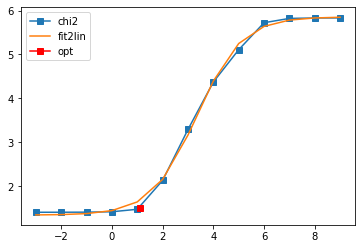

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


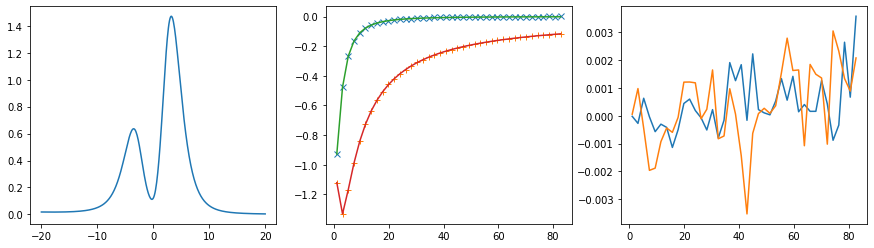

401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 9.00,	chi2 = 2.587e+05,   S = -1.459e-08,   nfev = 7,   norm = 9.000
log10(alpha) = 8.00,	chi2 = 2.581e+05,   S = -1.455e-06,   nfev = 15,   norm = 9.004
log10(alpha) = 7.00,	chi2 = 2.530e+05,   S = -1.423e-04,   nfev = 21,   norm = 9.040
log10(alpha) = 6.00,	chi2 = 2.101e+05,   S = -1.138e-02,   nfev = 26,   norm = 9.364
log10(alpha) = 5.00,	chi2 = 8.735e+04,   S = -2.497e-01,   nfev = 28,   norm = 10.733
log10(alpha) = 4.00,	chi2 = 2.374e+04,   S = -1.311e+00,   nfev = 30,   norm = 11.318
log10(alpha) = 3.00,	chi2 = 2.221e+03,   S = -4.292e+00,   nfev = 55,   norm = 10.354
log10(alpha) = 2.00,	chi2 = 1.513e+02,   S = -6.728e+00,   nfev = 58,   norm = 9.831
log10(alpha) = 1.00,	chi2 = 2.791e+01,   S = -8.065e+00,   nfev = 72,   norm = 9.683
log10(alpha) = 0.00,	chi2 = 2.456e+01,   S = -8.398e+00,   nfev = 34,   norm = 9.657
log10(alpha) 

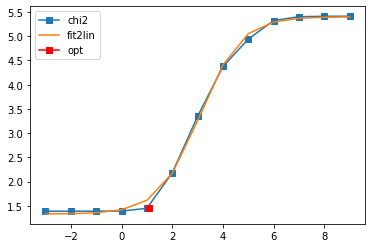

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


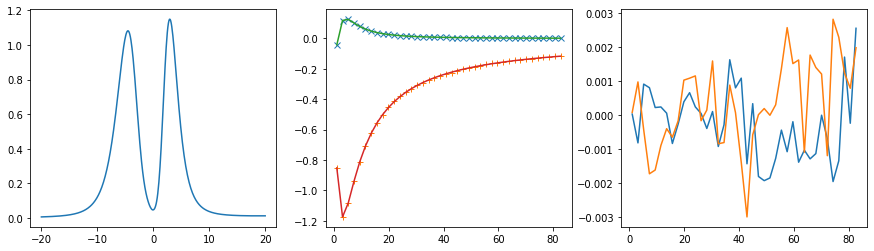

401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 9.00,	chi2 = 2.592e+05,   S = -1.385e-08,   nfev = 7,   norm = 9.000
log10(alpha) = 8.00,	chi2 = 2.587e+05,   S = -1.382e-06,   nfev = 15,   norm = 9.004
log10(alpha) = 7.00,	chi2 = 2.538e+05,   S = -1.352e-04,   nfev = 20,   norm = 9.039
log10(alpha) = 6.00,	chi2 = 2.129e+05,   S = -1.087e-02,   nfev = 25,   norm = 9.350
log10(alpha) = 5.00,	chi2 = 9.153e+04,   S = -2.497e-01,   nfev = 28,   norm = 10.698
log10(alpha) = 4.00,	chi2 = 2.489e+04,   S = -1.360e+00,   nfev = 30,   norm = 11.318
log10(alpha) = 3.00,	chi2 = 2.364e+03,   S = -4.505e+00,   nfev = 55,   norm = 10.354
log10(alpha) = 2.00,	chi2 = 1.469e+02,   S = -7.057e+00,   nfev = 57,   norm = 9.829
log10(alpha) = 1.00,	chi2 = 2.922e+01,   S = -8.340e+00,   nfev = 73,   norm = 9.684
log10(alpha) = 0.00,	chi2 = 2.578e+01,   S = -8.695e+00,   nfev = 55,   norm = 9.658
log10(alpha) 

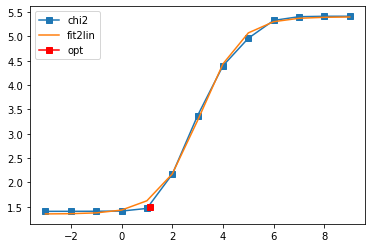

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


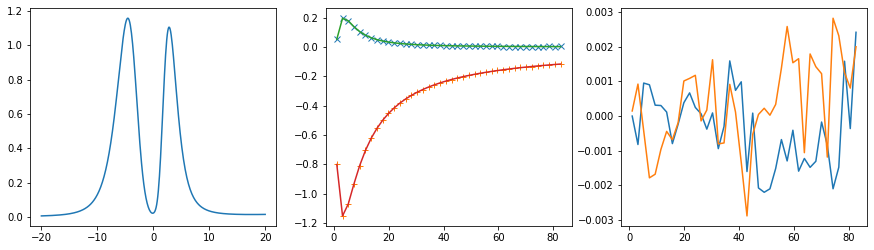

In [24]:
# define real frequencies, default model and error for continuation
nw = 401
w = np.linspace(-20., 20., num=nw, endpoint=True)
model = np.ones_like(w)
model /= np.trapz(model, w) / 9.  # for U=6 and half-filling, the norm is 9.
iw = np.pi / beta * (2. * np.arange(niw) + 1.)
err = np.ones_like(iw) * 2e-3
sw_diag = np.zeros((nw, 3, 3), dtype=np.complex)

for i in [0, 1, 2]:  # we have 3 eigenmodes
    # specify the problem
    probl = cont.AnalyticContinuationProblem(im_axis=iw,
                                             re_axis=w, 
                                             im_data=siw_projected[:, i, i] - hartree,  # subtract Hartree term
                                             kernel_mode='freq_fermionic')
    
    # solve the problem
    sol, _ = probl.solve(method='maxent_svd',
                         optimizer='newton',
                         alpha_determination='chi2kink',
                         model=model,
                         stdev=err,
                         interactive=True)
    
    # get full self-energy from Kramers Kronig
    sw_diag[:, i, i] = cont.GreensFunction(spectrum=sol.A_opt, wgrid=w, kind='fermionic').kkt() + hartree
    
    # plot
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
    ax[0].plot(w, sol.A_opt)
    ax[1].plot(iw, siw_projected[:, i, i].real - hartree, marker='x', ls='None')
    ax[1].plot(iw, siw_projected[:, i, i].imag, marker='+', ls='None')
    ax[1].plot(iw, sol.backtransform.real)
    ax[1].plot(iw, sol.backtransform.imag)
    ax[2].plot(iw, (siw_projected[:, i, i] - hartree - sol.backtransform).real)
    ax[2].plot(iw, (siw_projected[:, i, i] - hartree - sol.backtransform).imag)
    plt.show()

# go back to original basis
sw_rotated_back = states @ sw_diag @ states.T.conj()

Diagonal element 0
401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 9.00,	chi2 = 3.003e+05,   S = -1.797e-08,   nfev = 7,   norm = 9.000
log10(alpha) = 8.00,	chi2 = 2.996e+05,   S = -1.793e-06,   nfev = 15,   norm = 9.004
log10(alpha) = 7.00,	chi2 = 2.933e+05,   S = -1.755e-04,   nfev = 21,   norm = 9.043
log10(alpha) = 6.00,	chi2 = 2.400e+05,   S = -1.417e-02,   nfev = 26,   norm = 9.389
log10(alpha) = 5.00,	chi2 = 8.949e+04,   S = -3.016e-01,   nfev = 28,   norm = 10.814
log10(alpha) = 4.00,	chi2 = 2.324e+04,   S = -1.381e+00,   nfev = 30,   norm = 11.331
log10(alpha) = 3.00,	chi2 = 2.095e+03,   S = -4.284e+00,   nfev = 70,   norm = 10.348
log10(alpha) = 2.00,	chi2 = 1.421e+02,   S = -6.596e+00,   nfev = 59,   norm = 9.830
log10(alpha) = 1.00,	chi2 = 2.607e+01,   S = -7.838e+00,   nfev = 49,   norm = 9.684
log10(alpha) = 0.00,	chi2 = 2.308e+01,   S = -8.137e+00,   nfev = 44,   norm = 

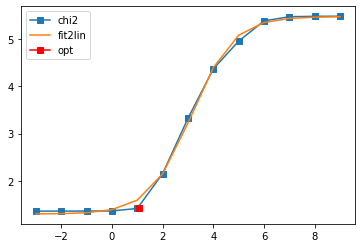

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


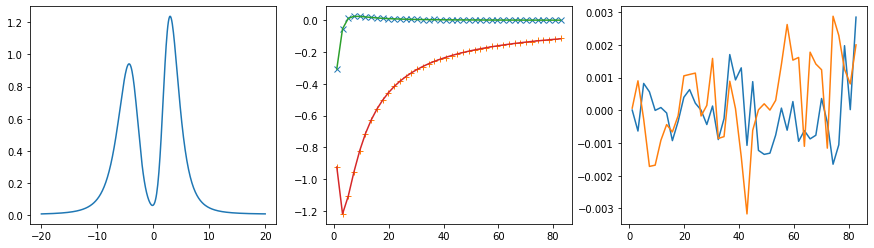

Diagonal element 1
401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 9.00,	chi2 = 3.010e+05,   S = -1.795e-08,   nfev = 7,   norm = 9.000
log10(alpha) = 8.00,	chi2 = 3.004e+05,   S = -1.791e-06,   nfev = 15,   norm = 9.004
log10(alpha) = 7.00,	chi2 = 2.940e+05,   S = -1.753e-04,   nfev = 21,   norm = 9.043
log10(alpha) = 6.00,	chi2 = 2.408e+05,   S = -1.416e-02,   nfev = 26,   norm = 9.389
log10(alpha) = 5.00,	chi2 = 9.008e+04,   S = -3.022e-01,   nfev = 28,   norm = 10.814
log10(alpha) = 4.00,	chi2 = 2.340e+04,   S = -1.389e+00,   nfev = 30,   norm = 11.332
log10(alpha) = 3.00,	chi2 = 2.099e+03,   S = -4.314e+00,   nfev = 68,   norm = 10.347
log10(alpha) = 2.00,	chi2 = 1.402e+02,   S = -6.623e+00,   nfev = 61,   norm = 9.830
log10(alpha) = 1.00,	chi2 = 2.604e+01,   S = -7.844e+00,   nfev = 49,   norm = 9.684
log10(alpha) = 0.00,	chi2 = 2.308e+01,   S = -8.141e+00,   nfev = 45,   norm = 

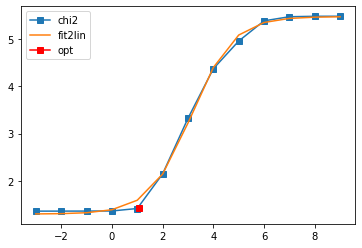

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


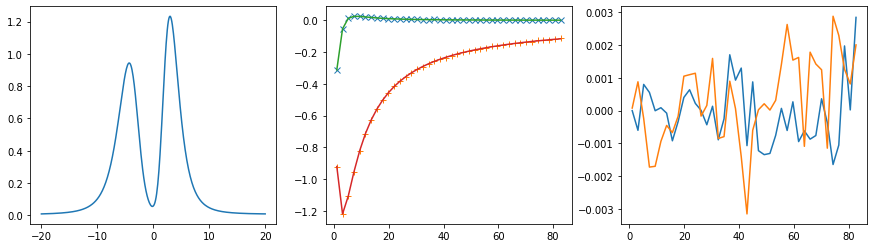

Diagonal element 2
401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 9.00,	chi2 = 2.994e+05,   S = -1.801e-08,   nfev = 7,   norm = 9.000
log10(alpha) = 8.00,	chi2 = 2.987e+05,   S = -1.797e-06,   nfev = 15,   norm = 9.004
log10(alpha) = 7.00,	chi2 = 2.924e+05,   S = -1.759e-04,   nfev = 21,   norm = 9.043
log10(alpha) = 6.00,	chi2 = 2.390e+05,   S = -1.420e-02,   nfev = 26,   norm = 9.390
log10(alpha) = 5.00,	chi2 = 8.866e+04,   S = -3.010e-01,   nfev = 28,   norm = 10.815
log10(alpha) = 4.00,	chi2 = 2.303e+04,   S = -1.370e+00,   nfev = 30,   norm = 11.330
log10(alpha) = 3.00,	chi2 = 2.089e+03,   S = -4.243e+00,   nfev = 71,   norm = 10.349
log10(alpha) = 2.00,	chi2 = 1.450e+02,   S = -6.559e+00,   nfev = 57,   norm = 9.831
log10(alpha) = 1.00,	chi2 = 2.612e+01,   S = -7.832e+00,   nfev = 55,   norm = 9.684
log10(alpha) = 0.00,	chi2 = 2.307e+01,   S = -8.135e+00,   nfev = 54,   norm = 

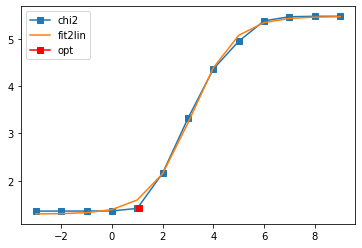

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


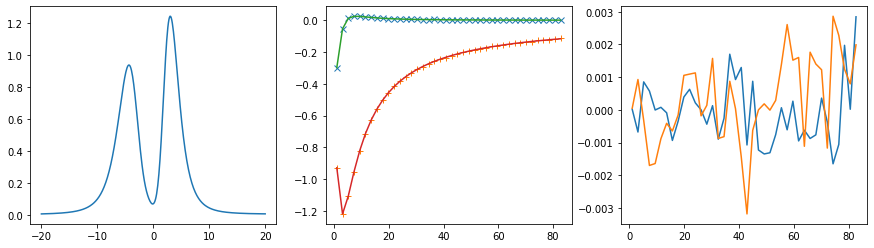

Offdiagonal element 0 1
401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 10.00,	chi2 = 6.525e+04,   S = -4.689e-10,   nfev = 1,   norm = 0.000
log10(alpha) = 9.00,	chi2 = 6.508e+04,   S = -4.676e-08,   nfev = 5,   norm = 0.000
log10(alpha) = 8.00,	chi2 = 6.344e+04,   S = -4.552e-06,   nfev = 14,   norm = 0.003
log10(alpha) = 7.00,	chi2 = 5.003e+04,   S = -3.542e-04,   nfev = 19,   norm = 0.018
log10(alpha) = 6.00,	chi2 = 1.220e+04,   S = -7.678e-03,   nfev = 29,   norm = 0.009
log10(alpha) = 5.00,	chi2 = 9.045e+02,   S = -2.131e-02,   nfev = 32,   norm = -0.079
log10(alpha) = 4.00,	chi2 = 5.157e+01,   S = -3.166e-02,   nfev = 25,   norm = -0.080
log10(alpha) = 3.00,	chi2 = 7.075e+00,   S = -3.665e-02,   nfev = 38,   norm = -0.048
log10(alpha) = 2.00,	chi2 = 2.438e+00,   S = -4.344e-02,   nfev = 25,   norm = -0.029
log10(alpha) = 1.00,	chi2 = 1.600e+00,   S = -5.622e-02,   nfev = 41,   n

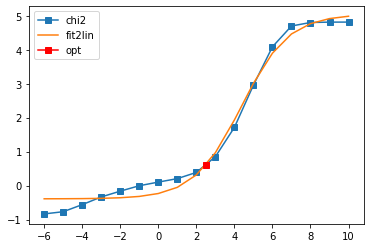

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


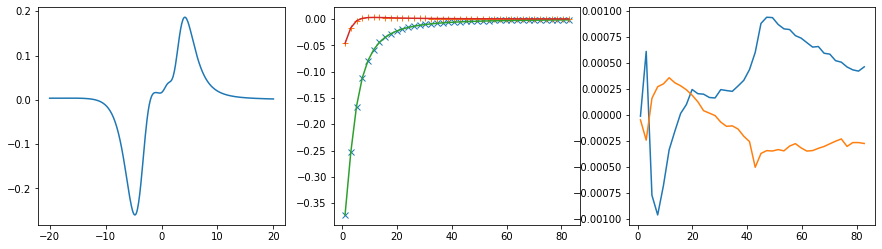

Offdiagonal element 0 2
401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 10.00,	chi2 = 3.497e+04,   S = -2.028e-10,   nfev = 1,   norm = -0.000
log10(alpha) = 9.00,	chi2 = 3.490e+04,   S = -2.023e-08,   nfev = 4,   norm = -0.001
log10(alpha) = 8.00,	chi2 = 3.418e+04,   S = -1.978e-06,   nfev = 13,   norm = -0.006
log10(alpha) = 7.00,	chi2 = 2.817e+04,   S = -1.601e-04,   nfev = 18,   norm = -0.053
log10(alpha) = 6.00,	chi2 = 8.684e+03,   S = -4.093e-03,   nfev = 24,   norm = -0.266
log10(alpha) = 5.00,	chi2 = 8.224e+02,   S = -1.443e-02,   nfev = 25,   norm = -0.337
log10(alpha) = 4.00,	chi2 = 8.786e+01,   S = -2.348e-02,   nfev = 26,   norm = -0.215
log10(alpha) = 3.00,	chi2 = 1.631e+01,   S = -3.355e-02,   nfev = 29,   norm = -0.126
log10(alpha) = 2.00,	chi2 = 2.891e+00,   S = -5.109e-02,   nfev = 35,   norm = -0.076
log10(alpha) = 1.00,	chi2 = 1.253e+00,   S = -7.461e-02,   nfev = 40

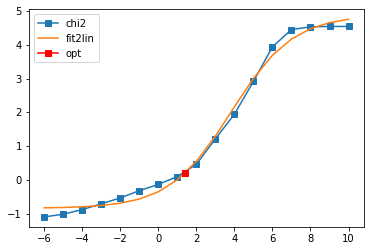

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


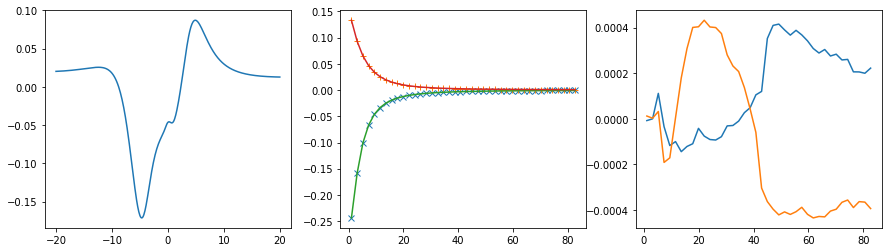

Offdiagonal element 1 0
401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 10.00,	chi2 = 6.523e+04,   S = -4.929e-10,   nfev = 1,   norm = 0.000
log10(alpha) = 9.00,	chi2 = 6.505e+04,   S = -4.915e-08,   nfev = 4,   norm = 0.001
log10(alpha) = 8.00,	chi2 = 6.332e+04,   S = -4.772e-06,   nfev = 13,   norm = 0.009
log10(alpha) = 7.00,	chi2 = 4.951e+04,   S = -3.635e-04,   nfev = 19,   norm = 0.076
log10(alpha) = 6.00,	chi2 = 1.316e+04,   S = -7.272e-03,   nfev = 23,   norm = 0.263
log10(alpha) = 5.00,	chi2 = 1.551e+03,   S = -2.290e-02,   nfev = 23,   norm = 0.203
log10(alpha) = 4.00,	chi2 = 6.559e+01,   S = -4.067e-02,   nfev = 25,   norm = 0.087
log10(alpha) = 3.00,	chi2 = 6.448e+00,   S = -4.680e-02,   nfev = 26,   norm = 0.048
log10(alpha) = 2.00,	chi2 = 2.318e+00,   S = -5.281e-02,   nfev = 25,   norm = 0.029
log10(alpha) = 1.00,	chi2 = 1.561e+00,   S = -6.424e-02,   nfev = 40,   norm 

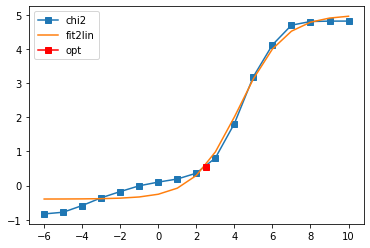

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


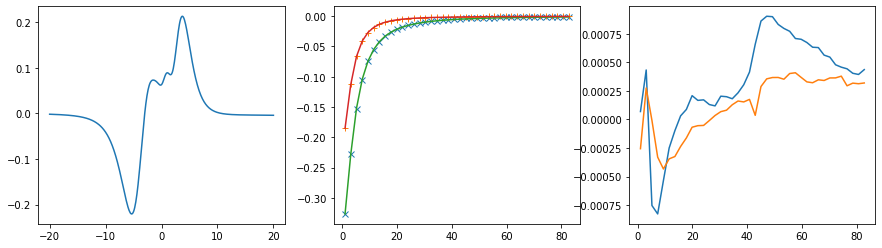

Offdiagonal element 1 2
401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 10.00,	chi2 = 4.747e+04,   S = -2.987e-10,   nfev = 1,   norm = -0.000
log10(alpha) = 9.00,	chi2 = 4.736e+04,   S = -2.980e-08,   nfev = 4,   norm = -0.000
log10(alpha) = 8.00,	chi2 = 4.631e+04,   S = -2.910e-06,   nfev = 13,   norm = -0.004
log10(alpha) = 7.00,	chi2 = 3.755e+04,   S = -2.328e-04,   nfev = 19,   norm = -0.037
log10(alpha) = 6.00,	chi2 = 1.036e+04,   S = -5.645e-03,   nfev = 24,   norm = -0.211
log10(alpha) = 5.00,	chi2 = 8.102e+02,   S = -1.752e-02,   nfev = 23,   norm = -0.296
log10(alpha) = 4.00,	chi2 = 8.474e+01,   S = -2.655e-02,   nfev = 26,   norm = -0.199
log10(alpha) = 3.00,	chi2 = 1.522e+01,   S = -3.605e-02,   nfev = 42,   norm = -0.116
log10(alpha) = 2.00,	chi2 = 3.075e+00,   S = -5.217e-02,   nfev = 26,   norm = -0.070
log10(alpha) = 1.00,	chi2 = 1.498e+00,   S = -7.510e-02,   nfev = 41

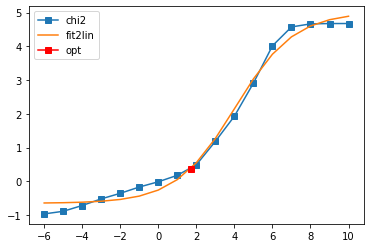

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


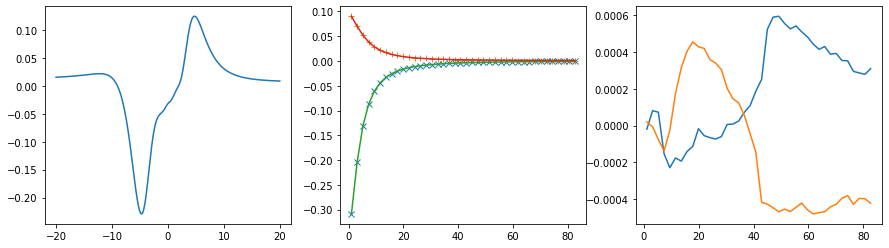

Offdiagonal element 2 0
401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 10.00,	chi2 = 3.499e+04,   S = -2.410e-10,   nfev = 1,   norm = 0.000
log10(alpha) = 9.00,	chi2 = 3.490e+04,   S = -2.402e-08,   nfev = 4,   norm = 0.001
log10(alpha) = 8.00,	chi2 = 3.406e+04,   S = -2.331e-06,   nfev = 13,   norm = 0.012
log10(alpha) = 7.00,	chi2 = 2.734e+04,   S = -1.765e-04,   nfev = 18,   norm = 0.101
log10(alpha) = 6.00,	chi2 = 9.609e+03,   S = -3.584e-03,   nfev = 23,   norm = 0.402
log10(alpha) = 5.00,	chi2 = 1.559e+03,   S = -1.607e-02,   nfev = 25,   norm = 0.399
log10(alpha) = 4.00,	chi2 = 1.045e+02,   S = -3.359e-02,   nfev = 28,   norm = 0.220
log10(alpha) = 3.00,	chi2 = 1.491e+01,   S = -4.495e-02,   nfev = 29,   norm = 0.126
log10(alpha) = 2.00,	chi2 = 2.747e+00,   S = -6.085e-02,   nfev = 39,   norm = 0.076
log10(alpha) = 1.00,	chi2 = 1.197e+00,   S = -8.279e-02,   nfev = 52,   norm 

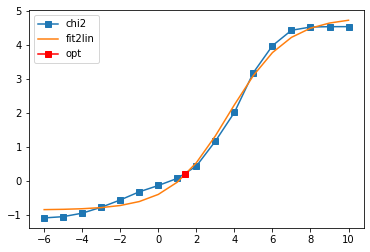

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


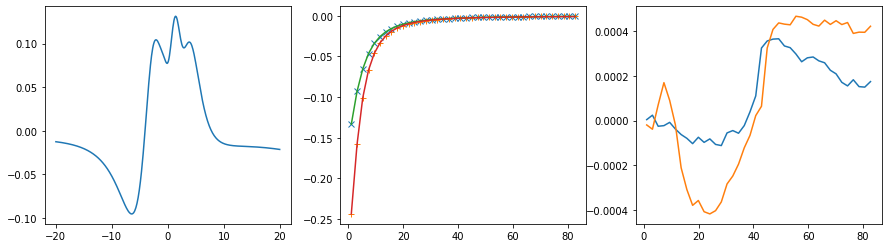

Offdiagonal element 2 1
401 data points on real axis
80 data points on imaginary axis
26 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 10.00,	chi2 = 4.751e+04,   S = -3.436e-10,   nfev = 1,   norm = 0.000
log10(alpha) = 9.00,	chi2 = 4.738e+04,   S = -3.426e-08,   nfev = 4,   norm = 0.001
log10(alpha) = 8.00,	chi2 = 4.618e+04,   S = -3.323e-06,   nfev = 13,   norm = 0.012
log10(alpha) = 7.00,	chi2 = 3.663e+04,   S = -2.511e-04,   nfev = 18,   norm = 0.104
log10(alpha) = 6.00,	chi2 = 1.183e+04,   S = -4.974e-03,   nfev = 23,   norm = 0.403
log10(alpha) = 5.00,	chi2 = 1.842e+03,   S = -2.002e-02,   nfev = 25,   norm = 0.385
log10(alpha) = 4.00,	chi2 = 1.071e+02,   S = -4.088e-02,   nfev = 29,   norm = 0.204
log10(alpha) = 3.00,	chi2 = 1.381e+01,   S = -5.215e-02,   nfev = 29,   norm = 0.116
log10(alpha) = 2.00,	chi2 = 2.879e+00,   S = -6.659e-02,   nfev = 26,   norm = 0.070
log10(alpha) = 1.00,	chi2 = 1.428e+00,   S = -8.733e-02,   nfev = 63,   norm 

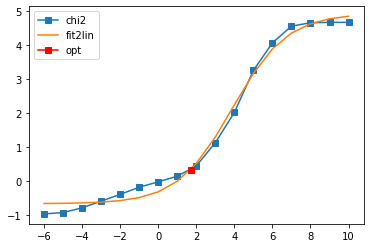

../../ana_cont/continuation.py:418: RuntimeWarning: divide by zero encountered in true_divide
  /(self.wgrid[None,:]-self.wgrid[:,None])


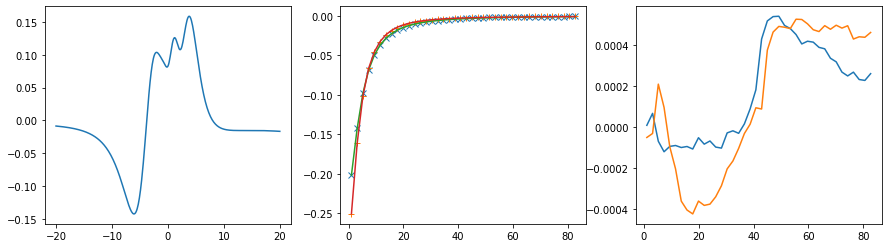

In [25]:
sw_full = np.zeros_like(sw_diag)


# first loop only over the diagonal elements
for i in [0, 1, 2]:
    print('Diagonal element {}'.format(i))
    
    # specify the problem
    probl = cont.AnalyticContinuationProblem(im_axis=iw,
                                             re_axis=w, 
                                             im_data=siw[:, i, i] - hartree,  # subtract Hartree term
                                             kernel_mode='freq_fermionic')
    
    # solve the problem 
    sol, _ = probl.solve(method='maxent_svd',
                         optimizer='newton',
                         alpha_determination='chi2kink',
                         model=model,
                         stdev=err,
                         interactive=True)
    
    # construct full self-energy by Kramers Kronig
    sw_full[:, i, i] = cont.GreensFunction(spectrum=sol.A_opt, wgrid=w, kind='fermionic').kkt() + hartree
    
    # plot
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
    ax[0].plot(w, sol.A_opt)
    ax[1].plot(iw, siw[:, i, i].real - hartree, marker='x', ls='None')
    ax[1].plot(iw, siw[:, i, i].imag, marker='+', ls='None')
    ax[1].plot(iw, sol.backtransform.real)
    ax[1].plot(iw, sol.backtransform.imag)
    ax[2].plot(iw, (siw[:, i, i] - hartree - sol.backtransform).real)
    ax[2].plot(iw, (siw[:, i, i] - hartree - sol.backtransform).imag)
    plt.show()
    
# now loop over the offdiagonal elements
for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        if i == j: continue
        print('Offdiagonal element {} {}'.format(i, j))
        
        # construct a good default model
        offdiag_model = np.sqrt(sw_full.imag[:, i, i] * sw_full.imag[:, j, j])  # "poorman's method" Kraberger et al.
        
        # specify the problem
        probl = cont.AnalyticContinuationProblem(im_axis=iw,
                                                 re_axis=w, 
                                                 im_data=siw[:, i, j],  # no Hartree term here!
                                                 kernel_mode='freq_fermionic')
        
        # solve the problem
        sol, _ = probl.solve(method='maxent_svd',
                             optimizer='newton',
                             alpha_determination='chi2kink',
                             model=offdiag_model,  # switch on offdiag mode
                             stdev=err,
                             offdiag=True,
                             alpha_start=1e10,
                             alpha_end=1e-6,
                             fit_position=1.5,  # smaller value to prevent overfitting
                             interactive=True)
        
        # construct full self-energy by Kramers Kronig
        sw_full[:, i, j] = cont.GreensFunction(spectrum=sol.A_opt, wgrid=w, kind='fermionic').kkt()
        
        # plot
        fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))
        ax[0].plot(w, sol.A_opt)
        ax[1].plot(iw, siw[:, i, j].real, marker='x', ls='None')
        ax[1].plot(iw, siw[:, i, j].imag, marker='+', ls='None')
        ax[1].plot(iw, sol.backtransform.real)
        ax[1].plot(iw, sol.backtransform.imag)
        ax[2].plot(iw, (siw[:, i, j] - sol.backtransform).real)
        ax[2].plot(iw, (siw[:, i, j] - sol.backtransform).imag)
        plt.show()

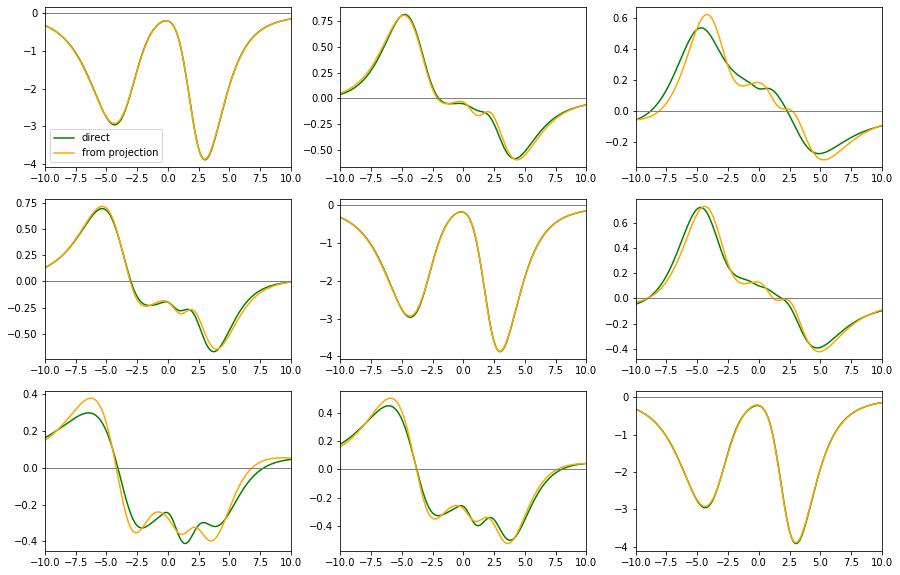

In [26]:
# now plot all matrix elements from both methods and compare
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15, 10))
for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        ax[i, j].plot(w, sw_full[:, i, j].imag, color='green', ls='-', label='direct')
        ax[i, j].plot(w, sw_rotated_back[:, i, j].imag, color='orange', ls='-', label='from projection')
        ax[i, j].set_xlim(-10., 10)
        ax[i, j].axhline(0., color='gray', lw=1)
ax[0, 0].legend()
plt.show()